In [1]:
from collections import defaultdict

import matplotlib.pyplot as plt
import torch
from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torch import nn
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.envs import (
    Compose,
    DoubleToFloat,
    ObservationNorm,
    StepCounter,
    TransformedEnv,
)
from torchrl.envs.libs.gym import GymEnv
from torchrl.envs.utils import check_env_specs, set_exploration_mode
from torchrl.modules import ProbabilisticActor, TanhNormal, ValueOperator
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
from tqdm import tqdm

In [2]:
!pip install tensordict torchrl gym['InvertedDoublePendulum-v2']


[notice] A new release of pip is available: 23.0 -> 23.1.2
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [2]:
device = "cpu" if not torch.has_cuda else "cuda:0"
print(device)
num_cells = 256  # number of cells in each layer
lr = 3e-4
max_grad_norm = 1.0

cpu


In [3]:
frame_skip = 1
frames_per_batch = 1000 // frame_skip
# For a complete training, bring the number of frames up to 1M
total_frames = 200_000 // frame_skip

In [4]:
sub_batch_size = 64  # cardinality of the sub-samples gathered from the current data in the inner loop
num_epochs = 10  # optimisation steps per batch of data collected
clip_epsilon = (
    0.2  # clip value for PPO loss: see the equation in the intro for more context.
)
gamma = 0.99
lmbda = 0.95
entropy_eps = 1e-4

In [5]:
from torchrl.envs import EnvBase
from tensordict.tensordict import TensorDictBase, TensorDict
from typing import Optional
import gym
from torchrl.data import CompositeSpec, BoundedTensorSpec, UnboundedContinuousTensorSpec, BinaryDiscreteTensorSpec, OneHotDiscreteTensorSpec, DiscreteTensorSpec

class MyEnv(EnvBase):
    def __init__(self, mode="LunarLander-v2", seed=None, device="cpu"):
        super().__init__(device=device, batch_size=[])
        self.base_env = gym.make(mode)
        self.base_env.reset()
        self._make_specs()
        
        if seed is None:
            seed = torch.empty((), dtype=torch.long).random_().item()
        self.set_seed(seed)
        
    def _step(self, tensordict: TensorDictBase) -> TensorDictBase:
        action = tensordict['action'].argmax().item()
        obs, reward, done, _ = self.base_env.step(action)
        out = TensorDict(
            {
                "next": {
                    "observation": torch.tensor(obs, dtype=torch.float32),
                    "reward": torch.tensor(reward, dtype=torch.float32),
                    "done": torch.tensor(done, dtype=torch.bool),
                }
            },
            tensordict.shape,
        )
        return out
    
    def _reset(self, tensordict: TensorDictBase) -> TensorDictBase:
        if tensordict is None or tensordict.is_empty():
            return TensorDict(
            {
                "observation": torch.tensor(self.base_env.reset(), dtype=torch.float32),
            },
            batch_size=self.batch_size,
        ) 
        return TensorDict(
            {
                "observation": tensordict['observation'],
            },
            batch_size=tensordict.shape,
        )
    
    def _set_seed(self, seed: Optional[int]):
        rng = torch.manual_seed(seed)
        self.rng = rng

    def _make_specs(self) -> None:
        self.action_spec = BinaryDiscreteTensorSpec(
            self.base_env.action_space.n,
            dtype=torch.float32
        )
        observation_spec = UnboundedContinuousTensorSpec(
            self.base_env.observation_space.shape, 
            dtype=torch.float32
        )
        if not isinstance(observation_spec, CompositeSpec):
            observation_spec = CompositeSpec(observation=observation_spec)
            
        self.observation_spec = observation_spec
        self.reward_spec = UnboundedContinuousTensorSpec(
            shape=[1],
            dtype=torch.float32,
        )
 

In [6]:
# base_env = GymEnv("LunarLander-v2", device=device, frame_skip=frame_skip)
my_env = MyEnv()

In [7]:
env = TransformedEnv(
    my_env,
    Compose(
        # normalize observations
        ObservationNorm(in_keys=["observation"]),
        DoubleToFloat(in_keys=["observation"]),
        StepCounter(),
    ),
)

In [8]:
env.transform[0].init_stats(num_iter=1000, reduce_dim=0, cat_dim=0)

In [9]:
print("normalization constant shape:", env.transform[0].loc.shape)

normalization constant shape: torch.Size([8])


In [10]:
print("observation_spec:", env.observation_spec)
print("reward_spec:", env.reward_spec)
print("input_spec:", env.input_spec)
print("action_spec (as defined by input_spec):", env.action_spec)

observation_spec: CompositeSpec(
    observation: UnboundedContinuousTensorSpec(
         shape=torch.Size([8]), space=None, device=cpu, dtype=torch.float32, domain=continuous),
    step_count: UnboundedDiscreteTensorSpec(
         shape=torch.Size([]), space=ContinuousBox(minimum=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int64, contiguous=True), maximum=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int64, contiguous=True)), device=cpu, dtype=torch.int64, domain=continuous), device=cpu, shape=torch.Size([]))
reward_spec: UnboundedContinuousTensorSpec(
     shape=torch.Size([1]), space=ContinuousBox(minimum=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, contiguous=True), maximum=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, contiguous=True)), device=cpu, dtype=torch.float32, domain=continuous)
input_spec: CompositeSpec(
    action: BinaryDiscreteTensorSpec(
         shape=torch.Size([4]), space=BinaryBox(n=4), device=cpu, dtype=torch.floa

In [11]:
check_env_specs(env)

check_env_specs succeeded!


In [12]:
rollout = my_env.rollout(3)
print("rollout of three steps:", rollout)
print("Shape of the rollout TensorDict:", rollout.batch_size)

rollout of three steps: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([3, 4]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([3, 8]), device=cpu, dtype=torch.float32, is_shared=False),
                reward: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([3]),
            device=cpu,
            is_shared=False),
        observation: Tensor(shape=torch.Size([3, 8]), device=cpu, dtype=torch.float32, is_shared=False),
        reward: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([3]),
    device=cpu,
    is_shared=False)
Shape of the ro

In [13]:
actor_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(env.action_spec.space.n, device=device),
    # NormalParamExtractor(),
)

/usr/local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [14]:
policy_module = TensorDictModule(
    actor_net, in_keys=["observation"], out_keys=["logits"]
)

In [15]:
from tensordict.nn.distributions import OneHotCategorical
policy_module = ProbabilisticActor(
    module=policy_module,
    spec=env.action_spec,
    in_keys=["logits"],
    distribution_class=OneHotCategorical,
    # distribution_kwargs={
    #     "n": env.action_spec.space.n,
    # },
    return_log_prob=True,
    # we'll need the log-prob for the numerator of the importance weights
)

In [16]:
value_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(1, device=device),
)

value_module = ValueOperator(
    module=value_net,
    in_keys=["observation"],
)

In [17]:
print("Running policy:", policy_module(env.reset()))
print("Running value:", value_module(env.reset()))

Running policy: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([4]), device=cpu, dtype=torch.int64, is_shared=False),
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        logits: Tensor(shape=torch.Size([4]), device=cpu, dtype=torch.float32, is_shared=False),
        observation: Tensor(shape=torch.Size([8]), device=cpu, dtype=torch.float32, is_shared=False),
        reward: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        sample_log_prob: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
        step_count: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int64, is_shared=False)},
    batch_size=torch.Size([]),
    device=cpu,
    is_shared=False)
Running value: TensorDict(
    fields={
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        observation: Tensor(shape=torch.Size([8]), device=cpu, dtype=tor

In [18]:
collector = SyncDataCollector(
    env,
    policy_module,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
    split_trajs=False,
    device=device,
)

In [19]:
for c in collector:
    break
c

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([1000, 4]), device=cpu, dtype=torch.int64, is_shared=False),
        collector: TensorDict(
            fields={
                traj_ids: Tensor(shape=torch.Size([1000]), device=cpu, dtype=torch.int64, is_shared=False)},
            batch_size=torch.Size([1000]),
            device=cpu,
            is_shared=False),
        done: Tensor(shape=torch.Size([1000, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        logits: Tensor(shape=torch.Size([1000, 4]), device=cpu, dtype=torch.float32, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([1000, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([1000, 8]), device=cpu, dtype=torch.float32, is_shared=False),
                reward: Tensor(shape=torch.Size([1000, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                step_count: Tensor(

In [21]:
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(frames_per_batch),
    sampler=SamplerWithoutReplacement(),
)

/usr/local/lib/python3.10/site-packages/torchrl/data/replay_buffers/replay_buffers.py:151: UserWarning: Constructing replay buffer without specifying behaviour is no longer recommended, and will be deprecated in the future.
  warnings.warn(


In [22]:
advantage_module = GAE(
    gamma=gamma, lmbda=lmbda, value_network=value_module, average_gae=True
)

loss_module = ClipPPOLoss(
    actor=policy_module,
    critic=value_module,
    advantage_key="advantage",
    clip_epsilon=clip_epsilon,
    entropy_bonus=bool(entropy_eps),
    entropy_coef=entropy_eps,
    # these keys match by default but we set this for completeness
    value_target_key=advantage_module.value_target_key,
    critic_coef=1.0,
    gamma=0.99,
    loss_critic_type="smooth_l1",
)

optim = torch.optim.Adam(loss_module.parameters(), lr=3e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#     optim, total_frames // frames_per_batch, 0.0
# )

In [23]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from collections import defaultdict
import numpy as np

class Logger:
    def __init__(self) -> None:
        self.logs = defaultdict(list)
        self.logs_mute = defaultdict(list)

    def log(self, key, value, mute=False):
        if not mute:
            self.logs[key].append(value)
        else:
            self.logs_mute[key].append(value)

    def plot(self, window_size=10, log_scale=False, start=0):

        def moving_average(a, window_size) :
            n = window_size
            ret = np.cumsum(a, dtype=float)
            ret[n:] = ret[n:] - ret[:-n]
            ma = ret[n - 1:] / n
            return np.append([ma[0]] * (n - 1), ma)
        
        ncols = 3
        nrows = (len(self.logs) - 1) // ncols + 1
        figure, axis = plt.subplots(nrows, ncols, figsize=(20, nrows * 5))
        for i, (k, v) in enumerate(self.logs.items()):
            r = i // ncols
            c = i % ncols
            v_plot = v[start:]
            if log_scale:
                v_plot = np.log(np.maximum(0.001, v[start:]))
            if nrows != 1:
                axis[r, c].plot(v_plot, c='b')
                axis[r, c].plot(moving_average(v_plot, window_size), c='r')
                axis[r, c].set_title(k)
            else:
                axis[c].plot(v, c='b')
                axis[c].plot(moving_average(v_plot, window_size), c='r')
                axis[c].set_title(k)
        plt.show()


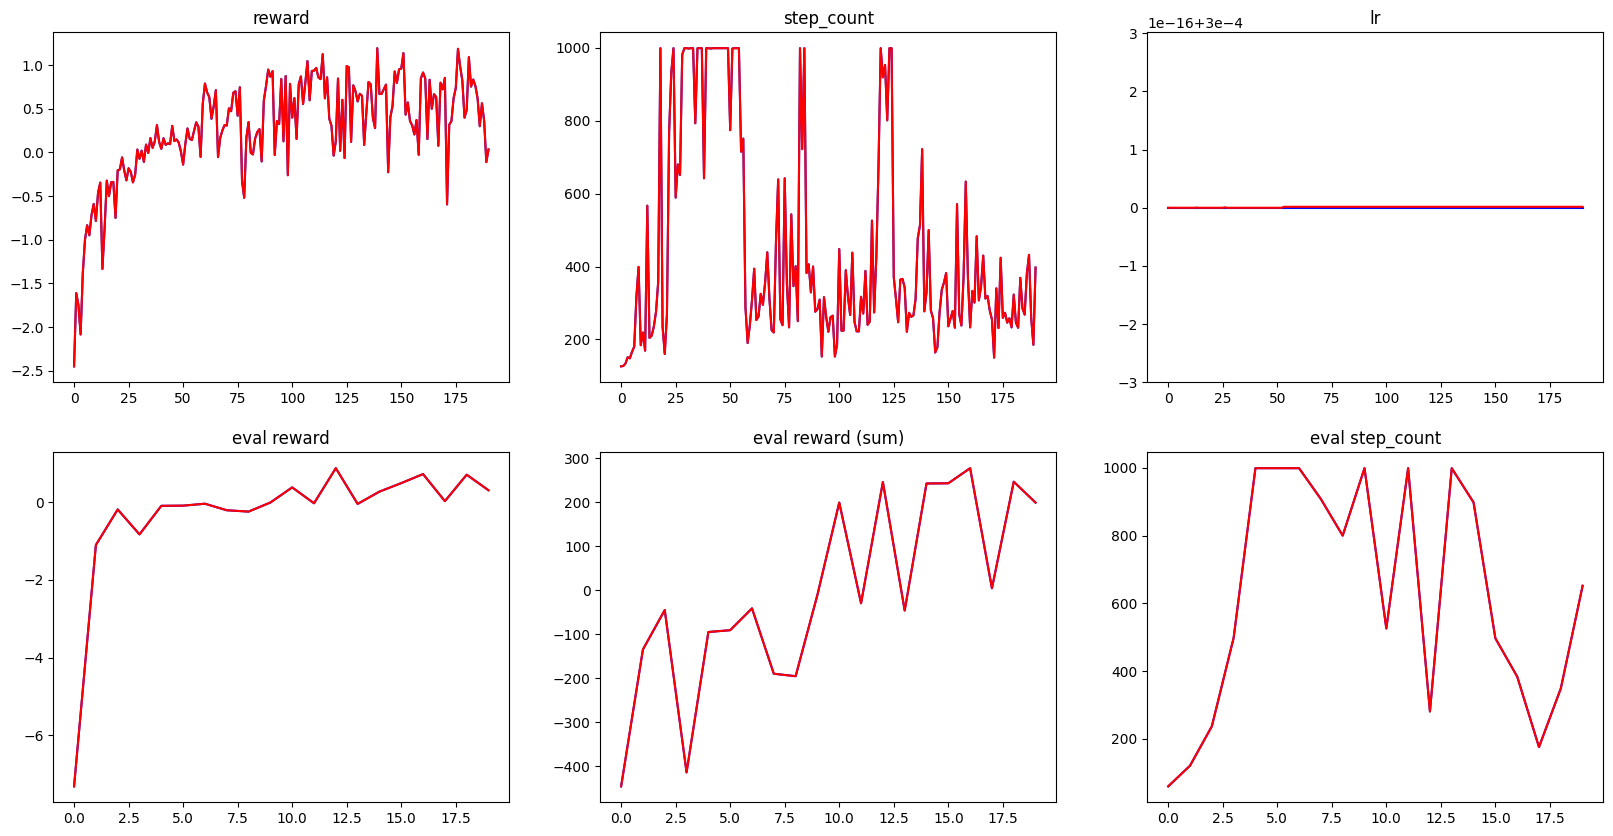

eval cumulative reward:  199.4267 (init: -446.1078), eval step-count: 652, average reward= 0.9620 (init=-2.4511), step count (max): 255, lr policy:  0.0003: 100%|██████████| 200000/200000 [13:29<00:00, 314.50it/s]

eval cumulative reward:  199.4267 (init: -446.1078), eval step-count: 652, average reward= 0.9620 (init=-2.4511), step count (max): 255, lr policy:  0.0003: 100%|██████████| 200000/200000 [13:40<00:00, 314.50it/s]

In [24]:
# logs = defaultdict(list)
pbar = tqdm(total=total_frames * frame_skip)
eval_str = ""
logger = Logger()

# We iterate over the collector until it reaches the total number of frames it was
# designed to collect:
for i, tensordict_data in enumerate(collector):
    # we now have a batch of data to work with. Let's learn something from it.
    for _ in range(num_epochs):
        # We'll need an "advantage" signal to make PPO work.
        # We re-compute it at each epoch as its value depends on the value
        # network which is updated in the inner loop.
        advantage_module(tensordict_data)
        data_view = tensordict_data.reshape(-1)
        replay_buffer.extend(data_view.cpu())
        for _ in range(frames_per_batch // sub_batch_size):
            subdata = replay_buffer.sample(sub_batch_size)
            loss_vals = loss_module(subdata.to(device))
            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            # Optimization: backward, grad clipping and optim step
            loss_value.backward()
            # this is not strictly mandatory but it's good practice to keep
            # your gradient norm bounded
            torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
            optim.step()
            optim.zero_grad()

    logger.log('reward', tensordict_data["next", "reward"].mean().item())
    # logs["reward"].append(tensordict_data["next", "reward"].mean().item())
    pbar.update(tensordict_data.numel() * frame_skip)
    cum_reward_str = (
        f"average reward={logger.logs['reward'][-1]: 4.4f} (init={logger.logs['reward'][0]: 4.4f})"
    )
    logger.log('step_count', tensordict_data["step_count"].max().item())
    # logs["step_count"].append(tensordict_data["step_count"].max().item())
    stepcount_str = f"step count (max): {logger.logs['step_count'][-1]}"
    logger.log('lr', optim.param_groups[0]["lr"])
    # logs["lr"].append(optim.param_groups[0]["lr"])
    lr_str = f"lr policy: {logger.logs['lr'][-1]: 4.4f}"
    if i % 10 == 0:
        # We evaluate the policy once every 10 batches of data.
        # Evaluation is rather simple: execute the policy without exploration
        # (take the expected value of the action distribution) for a given
        # number of steps (1000, which is our env horizon).
        # The ``rollout`` method of the env can take a policy as argument:
        # it will then execute this policy at each step.
        with torch.no_grad():
            # execute a rollout with the trained policy
            eval_rollout = env.rollout(1000, policy_module)
            logger.log('eval reward', eval_rollout["next", "reward"].mean().item())
            # logs["eval reward"].append(eval_rollout["next", "reward"].mean().item())
            logger.log('eval reward (sum)', eval_rollout["next", "reward"].sum().item())
            # logs["eval reward (sum)"].append(
            #     eval_rollout["next", "reward"].sum().item()
            # )
            logger.log('eval step_count', eval_rollout["step_count"].max().item())
            # logs["eval step_count"].append(eval_rollout["step_count"].max().item())
            eval_str = (
                f"eval cumulative reward: {logger.logs['eval reward (sum)'][-1]: 4.4f} "
                f"(init: {logger.logs['eval reward (sum)'][0]: 4.4f}), "
                f"eval step-count: {logger.logs['eval step_count'][-1]}"
            )
            del eval_rollout
        clear_output()
        logger.plot(1)
    pbar.set_description(", ".join([eval_str, cum_reward_str, stepcount_str, lr_str]))

    # We're also using a learning rate scheduler. Like the gradient clipping,
    # this is a nice-to-have but nothing necessary for PPO to work.
    # scheduler.step()

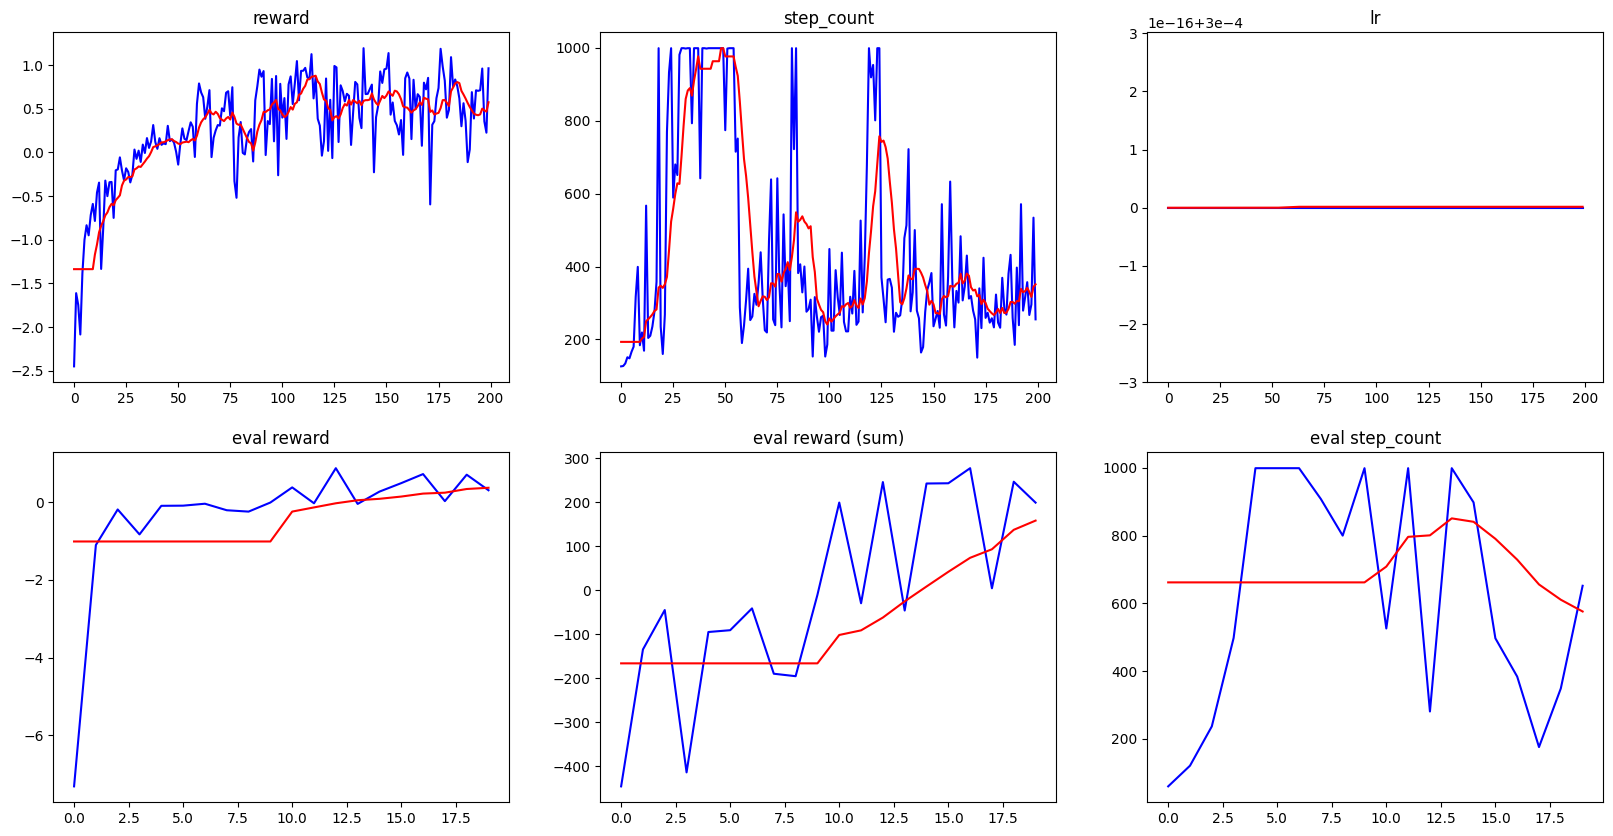

In [25]:
logger.plot(10)

# My RL